In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
# import seaborn as sns

# # Set style for better-looking plots
# sns.set_style("whitegrid")

In [13]:
hmf_interval_dir = "/home/jens/Dropbox/BafnaLab/ecDNA/pancancer/reclassification/HMF_AC_1_5_1/hmf_classification_bed_files/"
tcga_interval_dir = "/home/jens/Dropbox/BafnaLab/ecDNA/pancancer/reclassification/TCGA_cutoff_passed_AC_1_5_1/TCGA_classification_bed_files/"
pcawg_interval_dir = "/home/jens/Dropbox/BafnaLab/ecDNA/pancancer/reclassification/PCAWG_cutoff_passed_AC_1_5_1/PCAWG_classification_bed_files/"

In [14]:
# Create plots directory
os.makedirs('plots', exist_ok=True)

def merge_intervals_by_chrom(df, tol=30000):
    """
    Merge intervals within tolerance distance on same chromosome.
    """
    merged_intervals = []
    
    for chrom in df['chrom'].unique():
        chrom_df = df[df['chrom'] == chrom].sort_values('start').reset_index(drop=True)
        
        if len(chrom_df) == 0:
            continue
            
        # Start with first interval
        current_start = chrom_df.iloc[0]['start']
        current_end = chrom_df.iloc[0]['end']
        
        for idx in range(1, len(chrom_df)):
            next_start = chrom_df.iloc[idx]['start']
            next_end = chrom_df.iloc[idx]['end']
            
            # Check if intervals should be merged
            if next_start - current_end <= tol:
                # Merge by extending the end
                current_end = max(current_end, next_end)
            else:
                # Save current interval and start new one
                merged_intervals.append({
                    'chrom': chrom,
                    'start': current_start,
                    'end': current_end,
                    'length': current_end - current_start
                })
                current_start = next_start
                current_end = next_end
        
        # Don't forget the last interval
        merged_intervals.append({
            'chrom': chrom,
            'start': current_start,
            'end': current_end,
            'length': current_end - current_start
        })
    
    return pd.DataFrame(merged_intervals)

def process_ecdna_bed_files(directory, tol=30000, min_size=None):
    """
    Read all bed files containing '_ecDNA_' in filename,
    merge intervals within each file, then combine all files.
    """
    all_merged_intervals = []
    
    for filename in os.listdir(directory):
        if '_ecDNA_' in filename and filename.endswith('.bed'):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath, sep='\t', header=None, 
                           names=['chrom', 'start', 'end'])
            
            # Merge intervals within this file
            merged = merge_intervals_by_chrom(df, tol=tol)
            
            # Optional filtering by minimum size
            if min_size is not None:
                merged = merged[merged['length'] >= min_size]
            
            if not merged.empty:
                all_merged_intervals.append(merged)
    
    return pd.concat(all_merged_intervals, ignore_index=True) if all_merged_intervals else pd.DataFrame()

def fit_and_plot_distribution(data, dist_name, dist_func, ax_hist, ax_qq, fit_range=None):
    """
    Fit a distribution to data and create plots.
    Returns fitted parameters and goodness-of-fit statistics.
    """
    # Fit the distribution
    params = dist_func.fit(data)
    
    # Calculate goodness of fit
    ks_stat, ks_p = stats.kstest(data, lambda x: dist_func.cdf(x, *params))
    
    # Plot histogram with fitted distribution
    if fit_range is not None:
        x_range = np.linspace(fit_range[0], fit_range[1], 1000)
    else:
        x_range = np.linspace(data.min(), data.max(), 1000)
    
    ax_hist.hist(data, bins=50, alpha=0.7, edgecolor='black', density=True, label='Data')
    ax_hist.plot(x_range, dist_func.pdf(x_range, *params), 
                'r-', linewidth=2, label=f'{dist_name} fit')
    ax_hist.set_xlabel('Interval Length (kb)', fontsize=12)
    ax_hist.set_ylabel('Density', fontsize=12)
    ax_hist.set_title(f'{dist_name} Distribution', fontsize=14)
    ax_hist.legend()
    ax_hist.grid(alpha=0.3)
    
    # Q-Q plot
    stats.probplot(data, dist=dist_func, sparams=params, plot=ax_qq)
    ax_qq.set_title(f'Q-Q Plot: {dist_name}', fontsize=14)
    ax_qq.grid(alpha=0.3)
    
    return {
        'Distribution': dist_name,
        'KS Statistic': ks_stat,
        'KS P-value': ks_p,
        'Params': params
    }

Processing ecDNA bed files (merging within each file)...
  : 3656 merged intervals
  : 67 merged intervals
  : 1859 merged intervals

Total merged intervals across all datasets: 5582

Interval length statistics (kb):
  Mean: 963.37
  Median: 418.20
  Std: 1417.20
  Min: 10.02
  Max: 14200.93


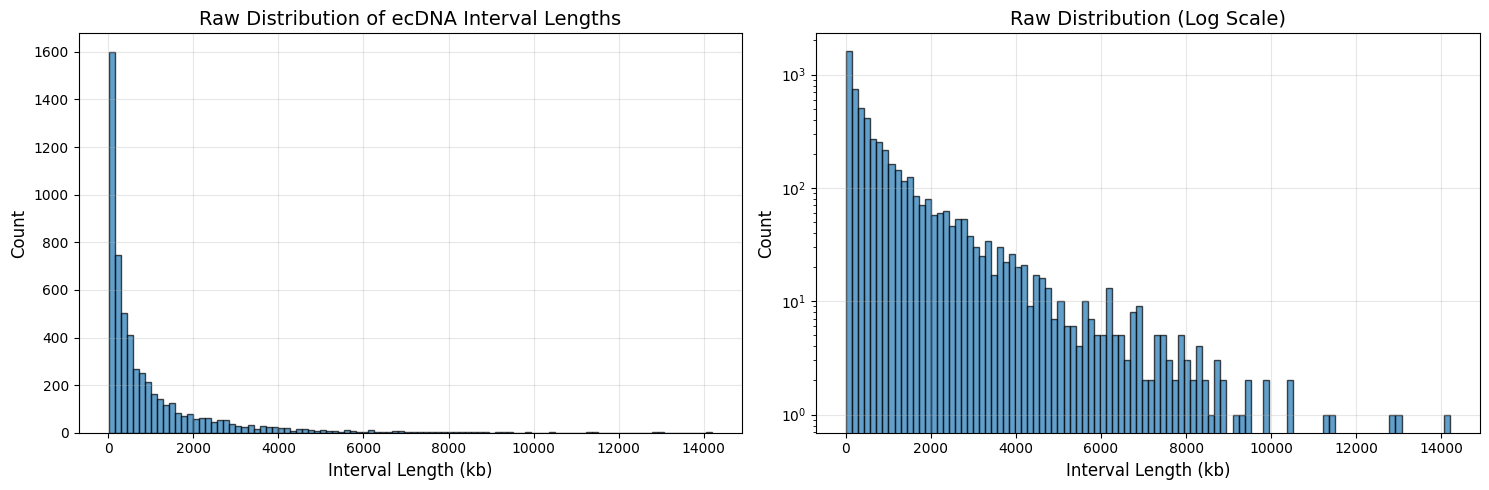


STRATEGY 1: Fitting to data in range [0-6000 kb] (no transformation)

Fitting to 5481 intervals in range [0, 6000] kb

Gamma:
  KS Statistic: 0.0335
  KS P-value: 8.5750e-06


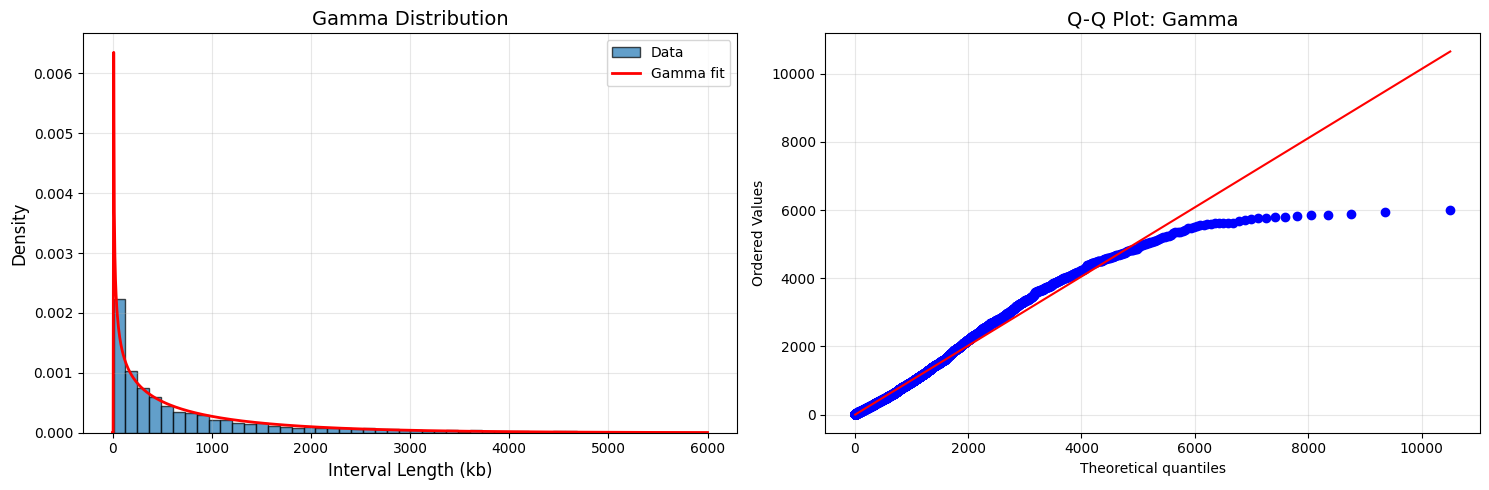


Lognormal:
  KS Statistic: 0.5563
  KS P-value: 0.0000e+00


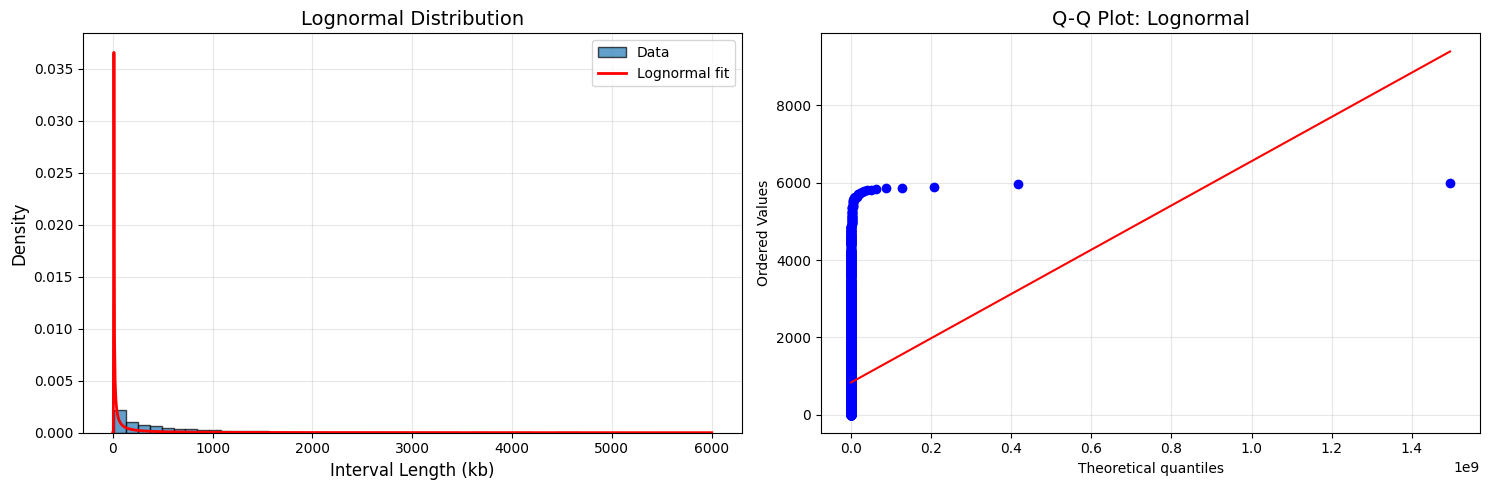


Exponential:
  KS Statistic: 0.1425
  KS P-value: 1.4019e-97


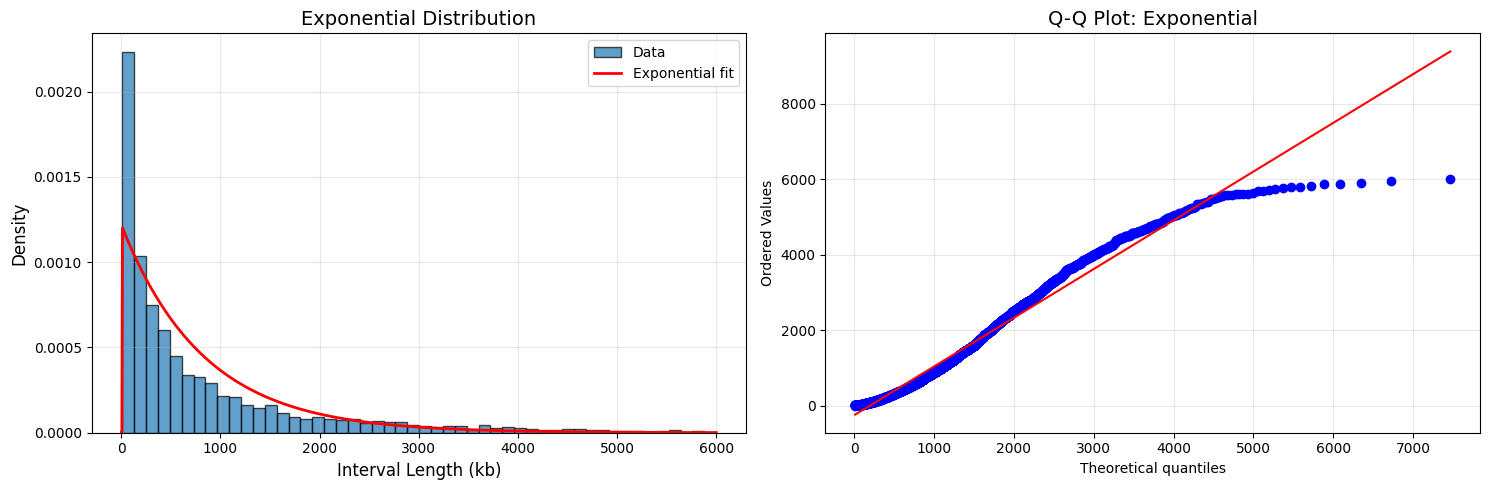


Weibull:
  KS Statistic: 0.0167
  KS P-value: 9.3396e-02


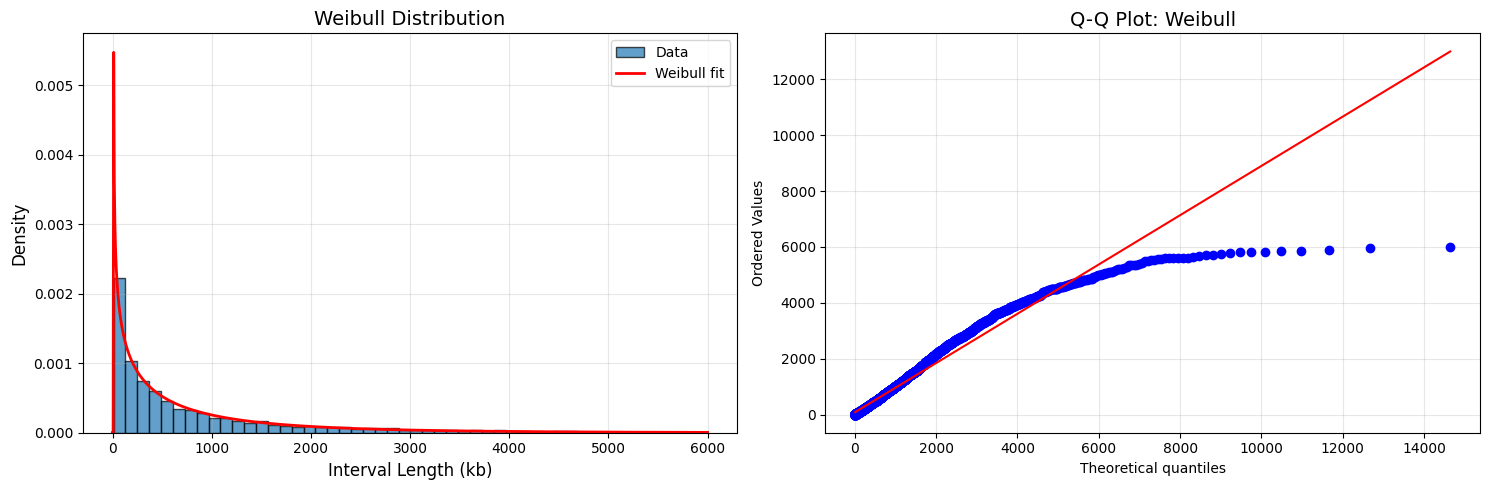


SUMMARY: Model Comparison

Strategy 1: Truncated range [50-1000 kb], no transformation
Distribution  KS Statistic   KS P-value
     Weibull      0.016688 9.339642e-02
       Gamma      0.033545 8.575029e-06
 Exponential      0.142502 1.401865e-97
   Lognormal      0.556272 0.000000e+00

Best fit (Strategy 1): Weibull (KS=0.0167)


In [16]:
# Process all directories
print("Processing ecDNA bed files (merging within each file)...")
tol = 150000  # 150kb tolerance
min_size = 10000  # Optional: filter intervals < 10kb (set to None to disable)

all_intervals = []
for directory in [hmf_interval_dir, tcga_interval_dir, pcawg_interval_dir]:
    if os.path.exists(directory):
        intervals = process_ecdna_bed_files(directory, tol=tol, min_size=min_size)
        if not intervals.empty:
            all_intervals.append(intervals)
            print(f"  {os.path.basename(directory)}: {len(intervals)} merged intervals")

# Combine all intervals
merged = pd.concat(all_intervals, ignore_index=True)
print(f"\nTotal merged intervals across all datasets: {len(merged)}")

# Get interval lengths
lengths = merged['length'].values / 1000  # Convert to kb

# Display basic statistics
print(f"\nInterval length statistics (kb):")
print(f"  Mean: {lengths.mean():.2f}")
print(f"  Median: {np.median(lengths):.2f}")
print(f"  Std: {lengths.std():.2f}")
print(f"  Min: {lengths.min():.2f}")
print(f"  Max: {lengths.max():.2f}")

# Plot raw distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.hist(lengths, bins=100, alpha=0.7, edgecolor='black')
ax.set_xlabel('Interval Length (kb)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Raw Distribution of ecDNA Interval Lengths', fontsize=14)
ax.grid(alpha=0.3)

ax = axes[1]
ax.hist(lengths, bins=100, alpha=0.7, edgecolor='black')
ax.set_xlabel('Interval Length (kb)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Raw Distribution (Log Scale)', fontsize=14)
ax.set_yscale('log')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/01_raw_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Strategy 1: Fit to truncated range [50kb, 1Mb]
print("\n" + "="*80)
fit_min = 0  # kb
fit_max = 6000  # kb
print(f"STRATEGY 1: Fitting to data in range [{fit_min}-{fit_max} kb] (no transformation)")
print("="*80)

fit_data_truncated = lengths[(lengths >= fit_min) & (lengths <= fit_max)]

print(f"\nFitting to {len(fit_data_truncated)} intervals in range [{fit_min}, {fit_max}] kb")

distributions = {
    'Gamma': stats.gamma,
    'Lognormal': stats.lognorm,
    'Exponential': stats.expon,
    'Weibull': stats.weibull_min,
}

results_truncated = []

for dist_name, dist_func in distributions.items():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    result = fit_and_plot_distribution(fit_data_truncated, dist_name, dist_func, 
                                      axes[0], axes[1], fit_range=(fit_min, fit_max))
    results_truncated.append(result)
    
    print(f"\n{dist_name}:")
    print(f"  KS Statistic: {result['KS Statistic']:.4f}")
    print(f"  KS P-value: {result['KS P-value']:.4e}")
    
    plt.tight_layout()
    plt.savefig(f'plots/02_truncated_{dist_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

# # Strategy 2: Left-shift transformation
# print("\n" + "="*80)
# print("STRATEGY 2: Left-shift transformation (drop <50kb, shift to 0)")
# print("="*80)

# truncate_below = 50  # kb
# lengths_filtered = lengths[lengths >= truncate_below]
# lengths_shifted = lengths_filtered - truncate_below

# print(f"\nFiltered to {len(lengths_shifted)} intervals >= {truncate_below} kb")
# print(f"After left-shift by {truncate_below} kb:")
# print(f"  Mean: {lengths_shifted.mean():.2f} kb")
# print(f"  Median: {np.median(lengths_shifted):.2f} kb")
# print(f"  Std: {lengths_shifted.std():.2f} kb")
# print(f"  Min: {lengths_shifted.min():.2f} kb")
# print(f"  Max: {lengths_shifted.max():.2f} kb")

# # Plot shifted distribution
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ax = axes[0]
# ax.hist(lengths_shifted, bins=100, alpha=0.7, edgecolor='black')
# ax.set_xlabel('Shifted Interval Length (kb)', fontsize=12)
# ax.set_ylabel('Count', fontsize=12)
# ax.set_title(f'Left-Shifted Distribution (truncated at {truncate_below} kb)', fontsize=14)
# ax.grid(alpha=0.3)

# ax = axes[1]
# ax.hist(lengths_shifted, bins=100, alpha=0.7, edgecolor='black')
# ax.set_xlabel('Shifted Interval Length (kb)', fontsize=12)
# ax.set_ylabel('Count', fontsize=12)
# ax.set_title('Left-Shifted Distribution (Log Scale)', fontsize=14)
# ax.set_yscale('log')
# ax.grid(alpha=0.3)

# plt.tight_layout()
# plt.savefig('plots/03_shifted_distribution.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Fit distributions to shifted data (cap at 950kb for fitting)
# fit_max_shifted = fit_max  # kb (corresponds to 1000kb in original scale)
# fit_data_shifted = lengths_shifted[lengths_shifted <= fit_max_shifted]

# print(f"\nFitting to {len(fit_data_shifted)} intervals in range [0, {fit_max_shifted}] kb (shifted)")

# results_shifted = []

# for dist_name, dist_func in distributions.items():
#     fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#     result = fit_and_plot_distribution(fit_data_shifted, dist_name, dist_func, 
#                                       axes[0], axes[1], fit_range=(0, fit_max_shifted))
#     results_shifted.append(result)
    
#     print(f"\n{dist_name}:")
#     print(f"  KS Statistic: {result['KS Statistic']:.4f}")
#     print(f"  KS P-value: {result['KS P-value']:.4e}")
    
#     plt.tight_layout()
#     plt.savefig(f'plots/04_shifted_{dist_name.lower()}.png', dpi=300, bbox_inches='tight')
#     plt.show()

# Summary comparison
print("\n" + "="*80)
print("SUMMARY: Model Comparison")
print("="*80)

print("\nStrategy 1: Truncated range [50-1000 kb], no transformation")
df_truncated = pd.DataFrame(results_truncated)
print(df_truncated[['Distribution', 'KS Statistic', 'KS P-value']].sort_values('KS Statistic').to_string(index=False))

# print("\nStrategy 2: Left-shifted (drop <50kb, shift to 0), fit [0-950 kb]")
# df_shifted = pd.DataFrame(results_shifted)
# print(df_shifted[['Distribution', 'KS Statistic', 'KS P-value']].sort_values('KS Statistic').to_string(index=False))

# Find best model
best_truncated = df_truncated.loc[df_truncated['KS Statistic'].idxmin()]

print("\n" + "="*80)
print(f"Best fit (Strategy 1): {best_truncated['Distribution']} (KS={best_truncated['KS Statistic']:.4f})")
# print(f"Best fit (Strategy 2): {best_shifted['Distribution']} (KS={best_shifted['KS Statistic']:.4f})")
print("="*80)

In [17]:
# For Strategy 1 (truncated)
gamma_truncated = [r for r in results_truncated if r['Distribution'] == 'Gamma'][0]
shape_trunc, loc_trunc, scale_trunc = gamma_truncated['Params']

print("Gamma parameters (Strategy 1]):")
print(f"  Shape (α): {shape_trunc:.8f}")
print(f"  Location: {loc_trunc:.8f}")
print(f"  Scale (β): {scale_trunc:.8f}")
print(f"  Mean: {shape_trunc * scale_trunc + loc_trunc:.2f} kb")

Gamma parameters (Strategy 1]):
  Shape (α): 0.61137261
  Location: 10.01800000
  Scale (β): 1353.57303871
  Mean: 837.56 kb
